## Q3: Recommender systems using AutoRec (30 Marks)

For this question we will be extending the autoencoder (similar to week 6 labs) as a recommender system. To do this, we will be training small autoencoders on incomplete data, where the zeros in incomplete data does not effect training. 

The technique is detailed in the following [paper](https://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf): Sedhain, S., Menon, A.K., Sanner, S. and Xie, L., 2015, May. _Autorec: Autoencoders meet collaborative filtering_. In Proceedings of the 24th international conference on World Wide Web (pp. 111-112).

We assume that each row of data corresponds to a person and the columns correspond to an item to be recommended. The numeric value (positive or negative) in each element corresponds to a users rating of an item, i.e., positive for a good rating and negative for a bad rating. Some of these entries will be incomplete and our job is predict the ratings for a user of these incomplete entries.

---

In [1]:
# Imports
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from framework.question_3.activation import Sigmoid, ReLU
from framework.question_3.realworld  import read_data
from framework.question_3.synthetic  import generate_synthetic
from framework.question_3.container  import Sequential
from framework.question_3.batcher    import MaskBatcher
from framework.question_3.linear     import Linear
from framework.question_3.linalg     import FrobeniusNorm
from framework.question_3.module     import Module
from framework.question_3.loss       import Loss, MSELoss, WeightedSumLoss

---
This question makes heavy use of prebuilt neural network code (the long list of imports). Although similar, there are a few notable differences when comparing the classes presented in the lab. Most notably, `forward_pass` has been renamed to `forward` and `backward_pass` has been renamed to `backward`. There are also a few quality of life changes (see `__call__`, with more details [here](https://docs.python.org/3/reference/datamodel.html)).

Full code of the framework is presented in `./framework/question_3`. Do **not** change the code here.

**Important notes**:
 - All functions which have randomisation **requires random seeds to be specified**! Mark deduction will be made if this is not the case.
 - When asked to define functions or classes **do not** use any global variables. Only those which are presented in the input. Failure to do so may result in full mark penalties.
 - Plots **must be appropriately labelled**. Deduction apply.
 - **Do not** change the inputs of any of the skeleton code given. Full mark deduction may apply as a result.
 - For any files read in your functions, make sure to use a **relative path** from the root directory created from extracting the assignment.

---

## Synthetic Dataset
We'll be using two different datasets. Firstly, we will be considering a synthetic dataset. 

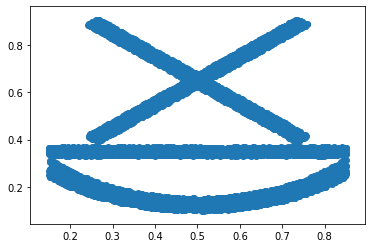

In [2]:
NUM_POINTS = 10_000

synthetic_data, categories = generate_synthetic(NUM_POINTS)

In [3]:
synthetic_data

array([[-1.30811542, -1.20945388, -0.83637615, -3.31886199,  0.82334734],
       [-2.94973624, -1.39539762, -0.17291061, -1.78101588, -0.84845431],
       [-3.70822657, -1.21376702, -0.28066327,  0.13060591, -1.18776946],
       ...,
       [ 2.30945332,  1.02227179, -0.34207969, -1.64166735,  1.53064911],
       [ 1.42394019,  0.08202302, -0.90886284, -5.30084446,  2.12430351],
       [ 1.64562646, -0.53556974, -0.96153519, -5.17831072,  1.76807171]])

You might want to explore the data, i.e., check dimensions and ranges.

In [4]:
# For you
synthetic_data.shape

(10000, 5)

Note that **all** the entries of the dataset are present. That is the data is **not** incomplete. To reiterate the introduction, we will represent missing data by 0. Your first task will be to make a function which randomly corrupts the data to make it missing.

### Question 3.1: Corrupting function (2 Marks)

To corrupt the data, you will have to complete the function `generate_mask` below which generates a randomised mask (depending on the `percentage` specified). More specifically, given any dataset we want to generate the matrix $ M $ which maps:

$$
\begin{bmatrix}
d_{11} & d_{12} & \cdots & d_{1N} \\
d_{21} & d_{22} & \cdots & d_{2N} \\
\vdots & & \ddots\\
d_{M1} & d_{M2} & \cdots & d_{MN} \\
\end{bmatrix}
\odot
M
\underbrace{\longrightarrow}_{\textrm{random }\%}
\begin{bmatrix}
d_{11} & 0 & \cdots & d_{1N} \\
0 & d_{22} & \cdots & 0 \\
\vdots & & \ddots\\
0 & d_{M2} & \cdots & 0 \\
\end{bmatrix}.
$$

Here $ \odot $ is a pointwise multiplication of the matrices.

`percentage` denotes the percentage of **missing** entries.

This should work for any dataset (don't hard code any constants). Here "dataset" refers to any $ N \times M $ numpy array.

In [5]:
def generate_observed_mask(dataset, percentage=0.1, seed=1337):
    
    ### TODO ###
    np.random.seed(seed = seed)
    data_vector = dataset.flatten()
    M = np.ones(len(data_vector))
    
    msk = np.random.rand(len(data_vector)) < percentage
    M[msk] = 0 
    mask = M.reshape((dataset.shape))
    ### TODO ###

    return mask

---

## Neural Network

Now that we have considered how to prepare the data, we will now define the neural network for our recommender system. Your first task here will be to complete the recommender class, which is similar to the autoencoder you defined in the week 6 lab. Additionally, there are a methods you will have to define for recommender systems specifically.

### Question 3.2: Recommender NN (5 Mask)
Complete the autoencoder recommender neural network. This include implmementing the `forward`, `backward`, `encode`, and `decode` methods, which should be very similar to the lab.

Additionally you will need to implement the `recommend_rating` method, which completes the incomplete input vector `x`. This means that the output should be the same dimension as the input. Furthermore, the complete part of the input should be the same in the output.

In [6]:
class AERecommender(Module):
    
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

    def init_weights(self, seed):
        self.encoder.init_weights(seed=seed)
        self.decoder.init_weights(seed=seed+1)

    def forward(self, x):
        super().forward(x)
        
        ### TODO ###
        value = self.encode(x)
        value = self.decode(value)
        ### TODO ###

        return value

    def backward(self, g_next_layer):
        
        ### TODO ###
        back_grad = self.decoder.backward(g_next_layer) 
        back_grad = self.encoder.backward(back_grad)
        ### TODO ###

        return back_grad

    def encode(self, x):
        
        ### TODO ###
        encoded = self.encoder.forward(x)
        ### TODO ###

        return encoded
    
    def decode(self, z):

        ### TODO ###
        decoded = self.decoder.forward(z)
        ### TODO ###
        
        return decoded
    
    def recommend_rating(self, x):

        ### TODO ###
        A = self.forward(x)
        rating = np.zeros(x.shape)
        
        if len(x.shape) == 1:
            #rating = np.zeros(len(x))
            A_ = A.reshape(-1,)
            
            for n in range(len(x)):
                if x[n] != 0:
                    rating[n] = x[n]
                else:
                    rating[n] = A_[n]
        
        else:
            nrow, ncol = x.shape
            rating = np.zeros(x.shape)
            for i in range(nrow):
                for j in range(ncol):
                    if x[i,j] != 0:
                        rating[i,j] = x[i,j]
                    else:
                        rating[i,j] = A[i,j]
        ### TODO ###
        
        return rating

    def update(self, learning_rate):
        self.encoder.update(learning_rate)
        self.decoder.update(learning_rate)

We have specified the recommender system's architecture as per the paper. This can be expressed as:
$$ \mathrm{Incomplete} \overset{\mathrm{Sigmoid}}{\underset{\mathrm{Linear}}{\longrightarrow}} Z = \mathbb{R}^{2} \overset{\mathrm{Id}}{\underset{\mathrm{Linear}}{\longrightarrow}} \mathrm{Pred. Complete}. $$

Or in equations:

$$ h({\mathbf r}; \theta) = f({\mathbf W} \cdot g({\mathbf V \mathbf r} + {\mathbf \mu}) + {\mathbf b}),$$
where $ f = \mathrm{Id} $ and $ g = \mathrm{Sigmoid} $.

Note: the `Sequential` class takes a list of neural network modules (of appropriate dimensions) and will apply them sequentially. So if we take a list `[f, g, h]`, then `Sequential([f, g, h])` will compose to output $ h(g(f(x))) = (h \circ g \circ f)(x) $.

In [7]:
def our_synthetic_recommender():
    encoder_linear = Linear(5, 2)
    decoder_linear = Linear(2, 5)
    
    my_encoder = Sequential([
        encoder_linear,
        Sigmoid()
    ])
    my_decoder = Sequential([
        decoder_linear,
    ])
    
    autoencoder = AERecommender(
        encoder=my_encoder,
        decoder=my_decoder
    )

    return autoencoder, encoder_linear, decoder_linear

---

## Loss function

In the previous section we have defined a recommender neural network. However, we need a way to train it and, more specifically, we need to train it only using the complete ratings. In the paper, this is specified as:

$$ \sum_{i=1} \Vert {\mathbf r}^{(i)} - h({\mathbf r}^{(i)}; \theta) \Vert_{\mathcal{O}}^{2} + \frac{\lambda}{2} \left( \Vert {\mathbf W} \Vert_{F}^{2} + \Vert {\mathbf V} \Vert_{F}^{2} \right), $$
where $ \Vert \cdot \Vert_{\mathcal{O}} $ only consider the contribution of the observed rating and $ \Vert \cdot \Vert_{F} $ is the Frobenious norm (this have been implemented for you). Further $ {\mathbf W} $ and $ {\mathbf V} $ corresponds to matrix weights of linear layers.

We will be modifying the MSE loss function for this. However, first we will define a generic class which will mask the influence of any loss function to only account for the observed components.

### Question 3.3: Observed Loss Function (5 Marks)

Complete the `ObservedLoss` class. You can use the assumption that the input loss function will follow the abstract class presented in `./framework/question_3/loss.py`. Thus they will have a well defined `forward` and `backward` function.

We further **assume** that input loss function incures no loss contribution when both `predicted` and `target` components are zero, i.e., in the MSE loss function if $ \hat x_{i} $ and $ x_{i} $ are both zero, you can ignore this index in the summation.

Note: there are a number of ways to do this. You might want to use a pen and paper to see how you might want to do this for a single vector in MSE.

In [8]:
class ObservedLoss(Loss):
    
    def __init__(self, loss):
        self.loss = loss

    def forward(self, *xs):
        super().forward(xs)

        predicted, target, observed_mask = xs
        
        ### TODO ###
        
        predicted_observed = np.multiply(predicted, observed_mask)
        target_observed = np.multiply(target, observed_mask)
        
        observed_loss = self.loss.forward(predicted_observed, target_observed)
        ### TODO ###

        return observed_loss

    def backward(self, g_next_layer=1):

        ### TODO ###
        observed_back_grad = self.loss.backward(g_next_layer)

        return observed_back_grad

Additional to the observed loss class, we also want to include regularization (as per the start of the section). We define the complete loss function as below:

In [9]:
def our_loss_gen(encoder_linear, decoder_linear, reg_w=1e-3):
    obs_loss = ObservedLoss(MSELoss())
    reg_encoder = FrobeniusNorm(encoder_linear)
    reg_decoder = FrobeniusNorm(decoder_linear)
    
    specified_loss = WeightedSumLoss([
        (obs_loss, 1.0),
        (reg_encoder, reg_w/2),
        (reg_decoder, reg_w/2)
    ])
    
    return specified_loss

---
## Synthetic Training

We now have the method for feeding data (the batcher), the model (the recommender neural network), and the loss function (the regularized observed loss). With these 3 components, we can train our recommender system.

### Question 3.4: Training recommender system for synthetic data (6 Marks)

Your task is to complete the following function which trains a recommender autoencoder `AERecommender` for some input data and a corresponding observation mask. You only need to edit the inner loop of the function.

Note: You will have to call `update` for the loss function.

In [10]:
def train_synthetic_recommender(synthetic_data, synthetic_mask,
                                seed=None,
                                training_epoch=50,
                                batch_size=100,
                                learning_rate=5e-3,
                                synthetic_recommender=our_synthetic_recommender,
                                loss_gen=our_loss_gen):
    
    # As defined in previous questions
    autoencoder, encoder_linear, decoder_linear = synthetic_recommender()
    loss_func = loss_gen(encoder_linear, decoder_linear)
    
    make_batch = lambda: MaskBatcher(synthetic_data, synthetic_mask,
                                     batch_size=batch_size)
    
    history = []
    
    # Initialise
    autoencoder.init_weights(seed=seed)
    
    for e in range(training_epoch):
        for xs, masks in make_batch()(seed=seed+e):

            ### TODO ###
            reconstructed = autoencoder.forward(xs)
            loss_val      = loss_func.forward(reconstructed, xs, masks)

            grad = loss_func.backward()
            autoencoder.backward(grad)
            
            autoencoder.update(learning_rate)
            loss_func.update(learning_rate)
            ### TODO ###

            history.append(loss_val)


    return autoencoder, history

With everything we can now use our recommender system.

---
## Exploring the synthetic dataset

Now that we have all the pieces, we can train and examine how our recommender system works. To do this, we will split our data into a train and test split. The following is an example index range for each of these splits.

In [11]:
train_index, test_index = train_test_split(range(synthetic_data.shape[0]), random_state=1337)

The code which you will have to do needs to be generic enough for any set of indices.

### Question 3.5: Examine the latent space (3 Marks)

The task is to examine the latent space. Complete the following function to create a scatter plot of the encoded latent space of the autoencoder recommender, for the test set. Use the default parameters of the `train_synthetic_recommender` function.

Colour the encoded points with respect to a k-means classifier (n=2).

Make sure the plot is formatted appropriately. You can call each dimension of the latent space as `latent dim 1` and `latent dim 2`.

In [12]:
from sklearn.cluster import KMeans

def plot_latent_autoencoder(synthetic_data, train_index, test_index, percentage,
                            seed=None,
                            generate_observed_mask=generate_observed_mask,
                            train_synthetic_recommender=train_synthetic_recommender):
    
    train_data = synthetic_data[train_index]
    test_data = synthetic_data[test_index]
    mask = generate_observed_mask(train_data, percentage, seed)
    autoencoder, history = train_synthetic_recommender(train_data, mask, seed = seed)
    
    encoded = autoencoder.encode(test_data)

    kmeans = KMeans(n_clusters = 2, random_state = 0).fit(encoded)
    
    group1 = encoded[kmeans.labels_ == 0]
    group2 = encoded[kmeans.labels_ == 1]

    
    fig, ax = plt.subplots(figsize = (9,9))
    
    ax.set_title('Encoded data')
    ax.scatter(group1[:,0], group1[:,1], color = 'darkseagreen')
    ax.scatter(group2[:,0], group2[:,1], color = 'lightpink')
    ax.set_xlabel('latent dim 1')
    ax.set_ylabel('latent dim 2')
    ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker = 'x',s=50, c = 'red')

    plt.show()

/Users/thaopham/me/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/thaopham/me/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The following is code for you to examine the recommender system:

/Users/thaopham/me/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/thaopham/me/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/thaopham/me/anaconda3/lib/pyt

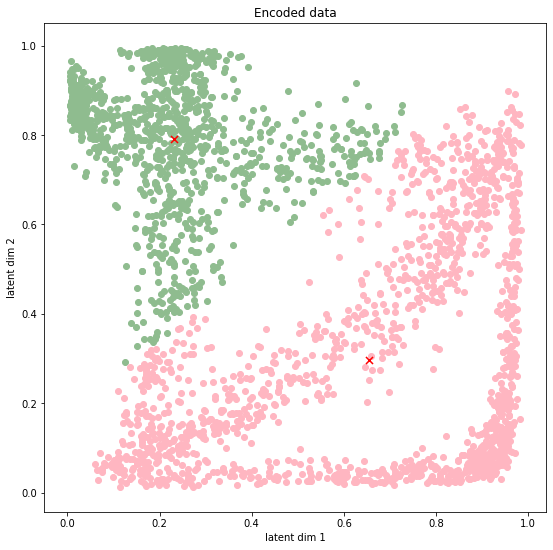

In [13]:
plot_latent_autoencoder(synthetic_data, train_index, test_index, 0.00, seed=1337)

---
## Real world data: MovieLens

Your last task will be an exploration of a real world dataset, MovieLens. We are using the [100K rating dataset](https://grouplens.org/datasets/movielens/100k/).

### Question 3.6 (9 Marks)

The final task is to do the following:
  1. Recommend a movie by **name** for the user 42;
  2. Determine if your recommendation matches other information in the dataset;
  3. Recommend a movie for each user and display the recommendation by genre with an appropriate plot.

To complete this, you will have to complete the following helper functions first:
  1. `your_movie_name`
  2. `your_genre_name`
  3. `your_movie_genres`
  4. `your_movie_recommender`
  5. `your_train_movie_recommender`
  6. `your_recommend_top`
  
For these helper functions you will need to read in files. Make sure to use a **relative path**.
  
For the recommender system `your_movie_recommender` you need to make, follow as we did in the synthetic dataset and only have a single linear layer with a sigmoid activation function for both the encoder and decoder networks.

Information about the data:
`movielens_data` have data where movies in columns and users in rows.

Additional files you may need for the question are found in `./data/question_3`.
The description of the files are as follow:

```
item     -- Information about the items (movies); this is a tab separated
            list of
            movie id | movie title | release date | video release date |
            IMDb URL | unknown | Action | Adventure | Animation |
            Children's | Comedy | Crime | Documentary | Drama | Fantasy |
            Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
            Thriller | War | Western |
            The last 19 fields are the genres, a 1 indicates the movie
            is of that genre, a 0 indicates it is not; movies can be in
            several genres at once.
            The movie ids are the ones used in the u.data data set.

genre    -- A list of the genres.

user     -- Demographic information about the users; this is a tab
            separated list of
            user id | age | gender | occupation | zip code
            The user ids are the ones used in the u.data data set.
```

In [14]:
MOVIELENS_PATH = './data/question_3/movie_data'

movielens_data = read_data(MOVIELENS_PATH)  # 0's signifies missing data

In [15]:
def your_movie_name(i):
    """ From movie id to movie name. Does not need to be fast.
    """
    ### TODO ###

    filepath = './data/question_3/item'
    with open(filepath, 'r') as f:
        while True:
            ln = f.readline().rstrip().split('|')

            movie_id, name = ln[0], ln[1]
            if int(movie_id) == i:
                return name

    return name

In [16]:
def your_genre_name(i):
    """ From genre id to genre name.
    """
    filepath = './data/question_3/genre'
    with open(filepath, 'r') as f:
        while True:
            ln = f.readline().rstrip().split('|')

            genre, genre_id = ln[0], ln[1]
            if int(genre_id) == i:
                return genre

    return name

In [17]:
def your_movie_genres(nmovies, ngenres=19):
    """ Make an array of genre information, rows as the movies and columns as indicator values for genres (sorted per data).
    """
    ### TODO ###
    genre_array = np.zeros((nmovies, ngenres), dtype = int)
    
    filepath = './data/question_3/item'
    with open(filepath, 'r') as f:
        for i in range(nmovies):
            ln = f.readline().rstrip().split('|')
            genres_ = ln[5:]
            for n in range(len(genres_)):
                genre_array[i,n] = int(genres_[n])
    
    return genre_array

In [18]:
def your_movie_recommender(nmovies):
    ### TODO ###
    encoder_linear = Linear(nmovies, 500)
    decoder_linear = Linear(500, nmovies)
    
    my_encoder = Sequential([encoder_linear, Sigmoid()])
    my_decoder = Sequential([decoder_linear, Sigmoid()])
    ### TODO ###

    autoencoder = AERecommender(
        encoder=my_encoder,
        decoder=my_decoder
    )

    return autoencoder, encoder_linear, decoder_linear

In [19]:
def your_train_movie_recommender(movie_data, nmovies,
                                 training_epoch=50,
                                 batch_size=100,
                                 learning_rate=5e-3,
                                 movie_recommender=your_movie_recommender,
                                 loss_gen=our_loss_gen,
                                 seed=None):

    autoencoder, encoder_linear, decoder_linear = movie_recommender(nmovies)
    loss_func = loss_gen(encoder_linear, decoder_linear)

    data = movie_data[:,:nmovies]
    
    make_batch = lambda: MaskBatcher(data= data, 
                                     data_mask=generate_observed_mask(data, percentage=0.0, seed=seed),
                                     batch_size=batch_size)
    history = []
    
    autoencoder.init_weights(seed=seed)
    
    for e in range(training_epoch):
        for xs, masks in make_batch()(seed=seed+e):
            
            reconstructed = autoencoder.forward(xs)
            loss_val      = loss_func.forward(reconstructed, xs, masks)
            
            grad = loss_func.backward()
            autoencoder.backward(grad)
            
            autoencoder.update(learning_rate)
            loss_func.update(learning_rate)
            
            history.append(loss_val)

    return autoencoder, history

In [20]:
def your_recommend_top(recommender, x):
    """ Recommends the highest predicted rating of the incomplete columns,
        i.e., should not return an item the user has already seen.
        This needs to be returned as the column index of the recommended item.
        
        Should work for vectorised x input.
    """
        
    ### TODO ###
    
    r = recommender.recommend_rating(x)

    highest_ind = -1
    highest_rating = float('-inf')
    for i in range(len(r)):
        if x[i] == 0:
            if r[i] > highest_rating:
                highest_rating = r[i]
                highest_ind = i

    
    top = highest_ind
    ### TODO ###

    return top

**Code for recommendation for user 42**:

In [21]:
def recommendation_for_42(movie_dataset,
                          movie_name=your_movie_name,
                          genre_name=your_genre_name,
                          movie_genres=your_movie_genres,
                          movie_recommender=your_movie_recommender,
                          train_movie_recommender=your_train_movie_recommender,
                          recommend_top=your_recommend_top,
                          seed=1337):
    ### TODO ###
    
    recommender, history = train_movie_recommender(movie_dataset, nmovies=movie_dataset.shape[1], seed=seed)
    
    user42 = movie_dataset[41,:]
    top = recommend_top(recommender, user42)
    recommend_id = top
    recommend_name = movie_name(recommend_id)
    ### TODO ###
    
    return recommend_id, recommend_name

In [22]:
r_id, r_name = recommendation_for_42(movielens_data, seed=1337)
print('Recommendation is:', r_name)

Recommendation is: Philadelphia Story, The (1940)


**Does the recommendation follow the user's training data? Why?**

In [23]:
def user_explore(movie_dataset,
                 movie_name=your_movie_name,
                 genre_name=your_genre_name,
                 movie_genres=your_movie_genres,
                 movie_recommender=your_movie_recommender,
                 train_movie_recommender=your_train_movie_recommender,
                 recommend_top=your_recommend_top,
                 seed=1337):
    
    #autoencoder, history = train_synthetic_recommender(train_data, mask, seed = seed)
    
    ### TODO ###
    user42 = movie_dataset[41,:]
    
    movies_genres_mat = movie_genres(movie_dataset.shape[1], 19)

    genre_dict = {}
    total_score = {}
   
    for i in range(len(user42)):
        if user42[i] != 0:
            # i = movie id
            print(movie_name(i), user42[i])
            movie = movies_genres_mat[i,:] # a vector of size 19, for 19 genres
            for n in range(len(movie)): 
                if movie[n] != 0:
                    gn = genre_name(n)
                    print(gn)
                    if gn not in genre_dict and gn not in total_score:
                        genre_dict[gn] = 0
                        total_score[gn] = 0 
                    genre_dict[gn] += 1
                    total_score[gn] += user42[i] # user 42's rating of the movie i
            print()
            
    sorted_genre_dict = sorted(genre_dict.items(), key=lambda x: x[1])

    labels, values = [], []
    avg_score = []
    
    for genre, num in sorted_genre_dict:
        labels.append(genre)
        values.append(num)
        avg_score.append(np.round(total_score[genre]/genre_dict[genre],2))
    
    # Drawing plot
    fig, ax = plt.subplots(figsize = (16, 9))
    ax.grid(axis='x', alpha = 0.5)
    
    ax.barh(labels, avg_score, height = 0.4, color = 'darkseagreen')

    n = 0
    for i in ax.patches:
 
        plt.text(i.get_width() + 0.02, i.get_y() + 0.1, values[n], 
                 fontsize = 13, fontweight ='bold', color ='grey')
        n+=1

    ax.set_title("User 42's watching activity", fontsize = 15)
    ax.set_xlabel("Average Score", fontsize = 14)
    ax.set_ylabel('Genre', fontsize = 14)

    plt.show()

Disclosure (1994) 0.5
Drama
Thriller

Aladdin (1992) 2.5
Action
Sci-Fi
Thriller

Heat (1995) 2.5
Comedy
Romance

Ghost (1990) 0.5
Action
Adventure
Crime
Drama

Aladdin and the King of Thieves (1996) 2.5
Children's
Drama
Fantasy
Sci-Fi

Vampire in Brooklyn (1995) 0.5
Action
Thriller

Hour of the Pig, The (1993) 2.5
Animation
Children's
Musical

Three Caballeros, The (1945) 0.5
Animation
Children's

Crooklyn (1994) 0.5
Drama
Romance

Shooter, The (1995) 1.5
Comedy
Romance



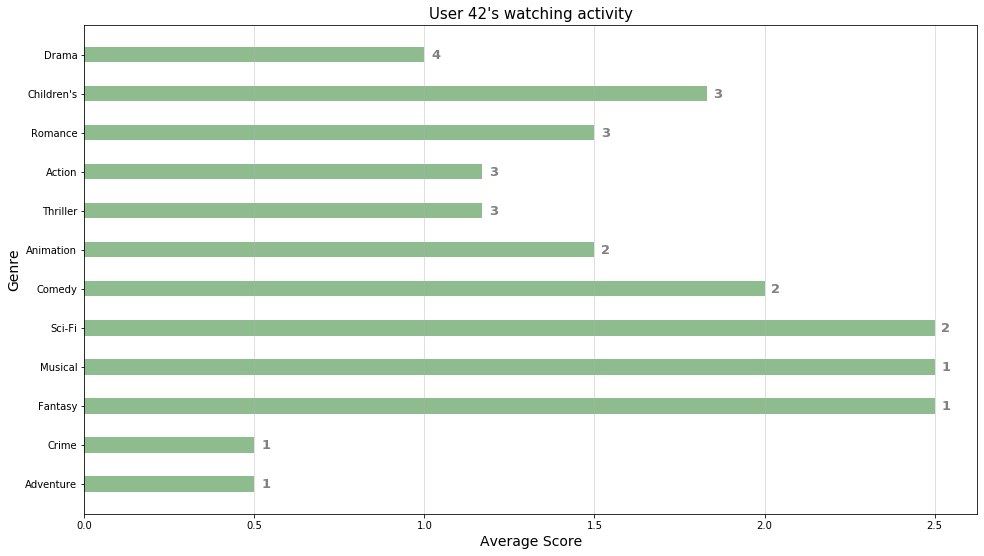

In [24]:
user_explore(movielens_data, seed=1337)

Above is the user's watching activity plotted by genres. The position of the bar representing each genre relative to whole graph is based on the number of times User 42 has watched a movie of that genre. Furthermore, the length of the bar is according to the average score User 42 has given to this genre. Thus, from the above graph we can see that User 42 has watched 4 Drama movies and his/her average score for this genre is 1.0. He/she also has watched 3 Children's movies and his/her average for this genre is from 1.5 to 2.0 (1.83 to be exact), and so on.

Note that the score for each movie is ranging from (-2.5 to 2.5). 

Our recommendation system has suggested the movie **"The Philadelphia Story (1940)"** to User 42 (recommendation is done below), which is a classic Romatic Comedy movie. I believe that our recommender has followed the user's training data closely. From the plot, it is visible that Romance is one of the more-watched genres of User 42. Furthermore, while User 42 has only watched 2 Comedy movies, the average rating User 42 has given across these two movies is very high, 2 out of 2.5. Therefore, "The Philadelphia Story (1940)" is a suitable recommendation for User 42.

**Your recommendations and genres**:

In [25]:
def recommendation_and_genres(movie_dataset,
                              movie_name=your_movie_name,
                              genre_name=your_genre_name,
                              movie_genres=your_movie_genres,
                              movie_recommender=your_movie_recommender,
                              train_movie_recommender=your_train_movie_recommender,
                              recommend_top=your_recommend_top,
                              seed=1337):
    
    recommender, history = train_movie_recommender(movie_dataset, nmovies=movie_dataset.shape[1], seed=seed)
    
    user42 = movie_dataset[41,:]
    top = recommend_top(recommender, user42)
    
    recommend_id = top

    recommend_name = movie_name(recommend_id)
    print(recommend_name)
    
    movies_genres_mat = movie_genres(movie_dataset.shape[1], 19)

    recommended_movie_genres = []
    recommended_movie = movies_genres_mat[recommend_id-1,:]
    
    for n in range(len(recommended_movie)): 
        if recommended_movie[n] != 0:
            gn = genre_name(n)
            if gn not in recommended_movie_genres:
                recommended_movie_genres.append(gn)
                
    print('Genre: {}'.format(', '.join(recommended_movie_genres)))


In [26]:
recommendation_and_genres(movielens_data, seed=1337)

Philadelphia Story, The (1940)
Genre: Comedy, Romance


**Code for recommendation for any user**



In [27]:
def recommend_for_user(user_id, movie_dataset, seed,
                       movie_name=your_movie_name, 
                       genre_name=your_genre_name,
                       movie_genres=your_movie_genres,
                       movie_recommender=your_movie_recommender,
                       train_movie_recommender=your_train_movie_recommender,
                       recommend_top=your_recommend_top):
    
    # Exploring user 
    
    user_info = movie_dataset[user_id,:]
    movies_genres_mat = movie_genres(movie_dataset.shape[1])

    genre_dict = {}
    total_score = {}
   
    for i in range(len(user_info)):
        if user_info[i] != 0:
            # i = movie id
            print(movie_name(i), user_info[i])
            genres = []
            movie = movies_genres_mat[i,:] # a vector of size 19, for 19 genres
            for n in range(len(movie)): 
                if movie[n] != 0:
                    gn = genre_name(n)
                    if gn not in genres:
                        genres.append(gn)
                    if gn not in genre_dict and gn not in total_score:
                        genre_dict[gn] = 0
                        total_score[gn] = 0 
                    genre_dict[gn] += 1
                    total_score[gn] += user_info[i] # user 42's rating of the movie i
            print(', '.join(genres))
            print()
            
    sorted_genre_dict = sorted(genre_dict.items(), key=lambda x: x[1])

    labels, values, avg_score = [], [], []
    
    for genre, num in sorted_genre_dict:
        labels.append(genre)
        values.append(num)
        avg_score.append(np.round(total_score[genre]/genre_dict[genre],2))
    
    # Figure Size
    fig, ax = plt.subplots(figsize = (16, 9))
    ax.grid(axis='x', alpha = 0.5)
    ax.barh(labels, avg_score, height = 0.4, color = 'darkseagreen')
    
    n = 0
    for i in ax.patches:
        if i.get_width() < 0:
            plt.text(i.get_width() + 0.45, i.get_y()+0.1, values[n],
                 fontsize = 14, fontweight ='bold', color = 'white')
        else:
            plt.text(i.get_width() - 0.045, i.get_y()+0.1, values[n],
                 fontsize = 14, fontweight ='bold', color = 'white')
        
        n+=1

    ax.set_title("User {}'s watching activity".format(user_id), fontsize = 15)
    ax.set_xlabel("Average Score", fontsize = 14)
    ax.set_ylabel('Genre', fontsize = 14)
    plt.show()
    
    recommender, history = train_movie_recommender(movie_dataset, nmovies=movie_dataset.shape[1], seed=seed)
    top = recommend_top(recommender, user_info)
    
    recommend_id = top
    recommend_name = movie_name(recommend_id)
    print('Recommended movie: {}, Movie ID: {}'.format(recommend_name, recommend_id))
    
    recommended_movie_genres = []
    recommended_movie = movies_genres_mat[recommend_id-1,:]
    
    for n in range(len(recommended_movie)): 
        if recommended_movie[n] != 0:
            gn = genre_name(n)
            if gn not in recommended_movie_genres:
                recommended_movie_genres.append(gn)
                
    print('Genre: {}'.format(', '.join(recommended_movie_genres)))

Seven (Se7en) (1995) 1.5
Crime, Thriller

Professional, The (1994) 2.5
Crime, Drama

Frighteners, The (1996) 1.5
Drama, Mystery

Spitfire Grill, The (1996) 1.5
Action, Crime, Drama

Mr. Smith Goes to Washington (1939) 1.5
Drama

Fish Called Wanda, A (1988) 1.5
Comedy

Raiders of the Lost Ark (1981) 0.5
Sci-Fi

Sabrina (1995) 0.5
Drama, Romance

Down by Law (1986) 1.5
Comedy, Drama

Farewell My Concubine (1993) 2.5
Western



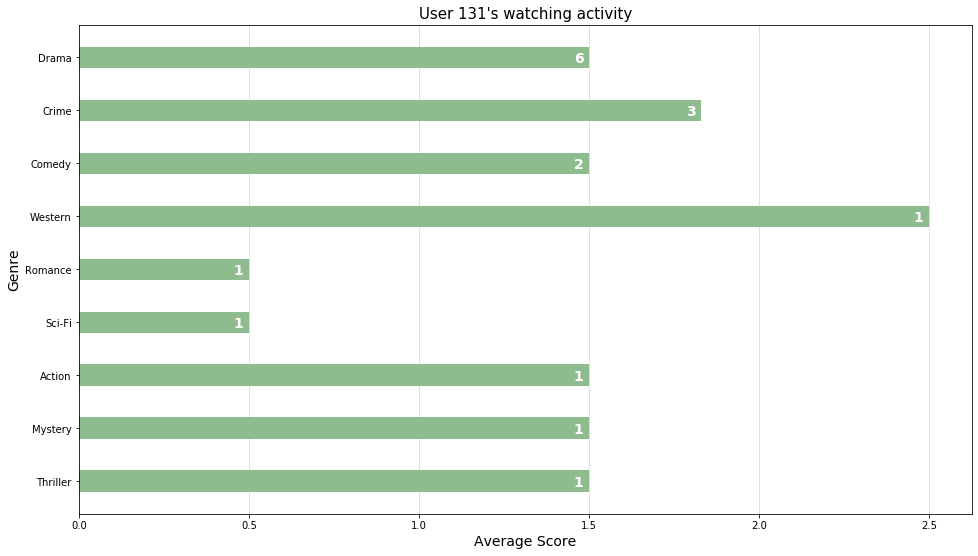

Recommended movie: Postino, Il (1994), Movie ID: 14
Genre: Drama, Romance


In [28]:
recommend_for_user(131, movielens_data, seed=1337)